In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from msresist.motifs import MapMotifs, AAlist
from msresist.clustering import compute_control_pssm
from msresist.figures.figure2 import plotMotifs
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices
from numba import prange

sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
ms = pd.read_csv("msresist/data/MS/AXL/AXL_MS_Anu.csv")

In [3]:
ms["Sequence"] = [s.replace("pY", "y") for s in ms["Sequence"]]
ms["Sequence"] = [s.replace("pS", "s") for s in ms["Sequence"]]
ms["Sequence"] = [s.replace("pT", "t") for s in ms["Sequence"]]

In [4]:
X = MapMotifs(ms, ms["Gene"])

In [5]:
bioID = pd.read_csv("msresist/data/MS/AXL/BioID_overlap.csv")
bioID.columns = ["BioID Genes"]
bioID = list(bioID.iloc[:, 0])
bioID.remove("ITGB1")

In [6]:
motifs = list(X.set_index("Gene").loc[bioID]["Sequence"])
motifs = [m.upper() for m in motifs]

In [7]:
pssm = compute_control_pssm(motifs)
pssm = pd.DataFrame(pssm)
pssm.columns = np.arange(11) + 1
pssm.index = AAlist

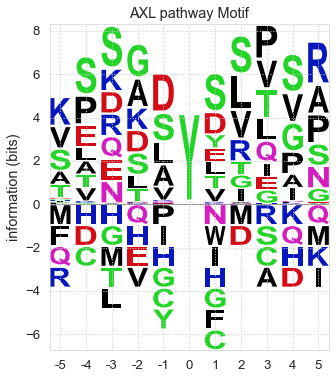

In [53]:
_, ax = plt.subplots(1, 1, figsize=(5,6))
plotMotifs([pssm], [ax], titles=["AXL pathway"])

In [9]:
def PAMdistMStoBioID(bioID, ms):
    ms_seq = list(X["Sequence"].values)
    pam250 = substitution_matrices.load("PAM250")
    pam250m = np.ndarray(pam250.shape, dtype=np.int8)
    for ii in range(pam250m.shape[0]):
        for jj in range(pam250m.shape[1]):
            pam250m[ii, jj] = pam250[ii, jj]

    bioID = np.array([[pam250.alphabet.find(aa) for aa in s] for s in bioID], dtype=np.intp)
    ms_seq = [s.upper() for s in ms_seq]
    ms_seq = np.array([[pam250.alphabet.find(aa) for aa in s] for s in ms_seq], dtype=np.intp)
    dists = []
    for msSeq in ms_seq:
        out = np.zeros((ms_seq.shape[0]))
        for ii in prange(bioID.shape[0]):
            for zz in range(bioID.shape[1]):
                out[ii] += pam250m[msSeq[zz], bioID[ii, zz]]
        dists.append(np.mean(out))

    # Table
    res = pd.DataFrame()
    res["Gene"] = ms["Gene"]
    res["Position"] = ms["Position"]
    res["PAM250 dist"] = dists
    res = res.sort_values(by="PAM250 dist", ascending=False)
    res.insert(0, "Rank", np.arange(ms.shape[0]) + 1)
    return res

In [19]:
dists = PAMdistMStoBioID(motifs, X)
dists = dists.set_index("Gene").drop(bioID)
dists["Rank"] = np.arange(dists.shape[0]) + 1
dists["Peptide"] = [g + ";" + p for g, p in list(zip(dists["Gene"], dists["Position"]))]

Text(0.5, 0, 'PAM250 score')

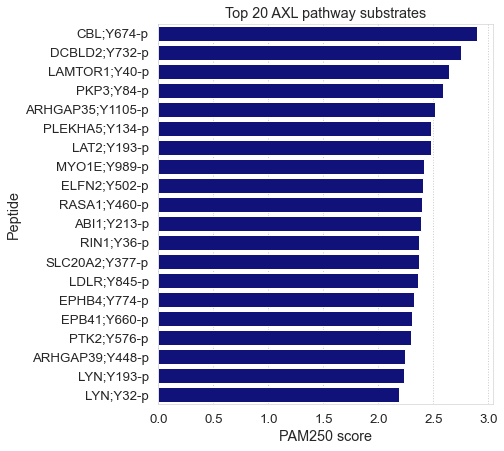

In [52]:
_, ax = plt.subplots(1, 1, figsize=(6, 7))
sns.barplot(data=dists.iloc[:20, :], x="PAM250 dist", y="Peptide", color="darkblue", ax=ax)
ax.set_title("Top 20 AXL pathway substrates")
ax.set_xlabel("PAM250 score")